# 4. Re-run the original model with log-differenced updated data

In [10]:
from IPython.display import display, HTML
import matplotlib as mpl
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np
import scipy
import os
import pandas as pd
import seaborn as sns
sns.set(style='ticks', rc={'axes.grid':True,
                           'xtick.labelsize': 'medium',
                           'ytick.labelsize': 'medium',
#                            'font.size': 15,
                          })

analysis_dir = os.getcwd()
assert analysis_dir.endswith(os.path.join('em-2020','analysis'))
plot_dir = os.path.realpath(os.path.join(analysis_dir, '..', 'tex', 'plots'))
data_dir = os.path.realpath(os.path.join(analysis_dir, '..', 'data'))

In [11]:
suppressMessages({
library(lavaan)
library(semPlot)
library(semTools)
library(MVN)
library(Hmisc)
library(data.table)
library(dplyr)
library(tseries)
})

In [12]:
%get data_dir --from em-2020
cols <- c('year', 'ISG', 'TO', 'TI', 'P_GDPb', 'EIb')
data.raw <- read.csv(file.path(data_dir, 'WB_BGD_current.csv'))[cols]

log_cols <- c('EIb', 'P_GDPb', 'TI')
data.log <- copy(data.raw)
data.log[log_cols] <- log(data.raw[log_cols])
data.logdiff <- cbind(data.raw[-1,'year', drop=FALSE], diff(as.matrix(subset(data.log, select=-year))))

data <- subset(data.raw, year >= 1986 & year <= 2015)
data.log <- subset(data.log, year >= 1986 & year <= 2015)
data.logdiff <- subset(data.logdiff, year >= 1986 & year <= 2015)

tail(data.logdiff)

,year,ISG,TO,TI,P_GDPb,EIb
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
51,2010,-0.339095455,-2.2899536,0.03571808,0.05455823,0.01393713
52,2011,0.088822874,9.6180072,-0.11122564,0.07187155,-0.04657900
53,2012,0.264659789,0.6900729,0.14571181,0.07062347,-0.03399079
54,2013,0.997110775,-1.8145200,-0.15556411,0.06422711,-0.05478407
55,2014,0.003976619,-1.7823225,-0.03356020,0.06616100,-0.03429612
56,2015,0.520348050,-2.4280839,0.14877301,0.06293288,NA


In [13]:
summary(lm('TI ~ ISG + TO', data=data.logdiff))


Call:
lm(formula = "TI ~ ISG + TO", data = data.logdiff)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.47959 -0.11372 -0.00194  0.12160  0.49902 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept) 0.019269   0.043521   0.443    0.661
ISG         0.018943   0.070597   0.268    0.790
TO          0.009005   0.014239   0.632    0.532

Residual standard error: 0.2197 on 27 degrees of freedom
Multiple R-squared:  0.0209,	Adjusted R-squared:  -0.05163 
F-statistic: 0.2881 on 2 and 27 DF,  p-value: 0.752


In [14]:
summary(lm('P_GDPb ~ TO', data=data.logdiff))


Call:
lm(formula = "P_GDPb ~ TO", data = data.logdiff)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.015948 -0.012304 -0.002614  0.010253  0.025051 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.0537131  0.0027073  19.840 5.76e-16 ***
TO          0.0020126  0.0008299   2.425   0.0236 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.01298 on 23 degrees of freedom
  (5 observations deleted due to missingness)
Multiple R-squared:  0.2036,	Adjusted R-squared:  0.169 
F-statistic: 5.881 on 1 and 23 DF,  p-value: 0.02356


In [15]:
summary(lm('EIb ~ ISG + TO + TI + P_GDPb', data=data.logdiff))


Call:
lm(formula = "EIb ~ ISG + TO + TI + P_GDPb", data = data.logdiff)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.057370 -0.014397 -0.000563  0.014938  0.048453 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)
(Intercept) -0.0047019  0.0239286  -0.196    0.846
ISG          0.0004422  0.0089744   0.049    0.961
TO           0.0007217  0.0020045   0.360    0.723
TI           0.0267926  0.0263886   1.015    0.323
P_GDPb      -0.4844747  0.4390350  -1.103    0.284

Residual standard error: 0.02575 on 19 degrees of freedom
  (6 observations deleted due to missingness)
Multiple R-squared:  0.1324,	Adjusted R-squared:  -0.05027 
F-statistic: 0.7248 on 4 and 19 DF,  p-value: 0.5858


In [30]:
model.path <- '
## path model
EIb ~ p_eib_isg*ISG + p_eib_to*TO + p_eib_ti*TI + p_eib_pgdpb*P_GDPb
TI ~ p_ti_to*TO
P_GDPb ~ p_pgdpb_to*TO
ISG ~ p_isg_ti*TI
## indirect effect
p_eib_ti_isg := p_eib_ti*p_isg_ti
p_eib_pgdpb_to := p_eib_pgdpb*p_pgdpb_to
## total effect
p_eib_ti_total := p_eib_ti + (p_eib_isg*p_isg_ti)
p_eib_to_total := p_eib_to + (p_eib_pgdpb*p_pgdpb_to) + (p_eib_ti*p_ti_to)
'

capture <- function(expr, file) {
    writeLines(c('\\begin{verbatim}', 
                 capture.output(expr),
                 '\\end{verbatim}'), con=file)
}
model.path.fit <- sem(model.path, data=data.logdiff, estimator='MLR', missing='ML', meanstructure=TRUE)
# capture(summary(model.path.fit, standardized=TRUE, header=TRUE,  fit.measures=TRUE, estimates=FALSE),
#         '../tex/plots/model.logdiff.fit.summary.tex')
# capture(summary(model.path.fit, standardized=TRUE, header=FALSE, estimates=TRUE),
#         '../tex/plots/model.logdiff.fit.estimates.tex')
summary(model.path.fit, standardized=TRUE, fit.measures=TRUE)

Warning message in lav_data_full(data = data, group = group, cluster = cluster, :
“lavaan WARNING: some observed variances are (at least) a factor 1000 times larger than others; use varTable(fit) to investigate”


lavaan 0.6-5 ended normally after 58 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of free parameters                         15
                                                      
  Number of observations                            30
  Number of missing patterns                         3
                                                      
Model Test User Model:
                                              Standard      Robust
  Test Statistic                                 2.741       3.600
  Degrees of freedom                                 3           3
  P-value (Chi-square)                           0.433       0.308
  Scaling correction factor                                  0.761
    for the Yuan-Bentler correction (Mplus variant) 

Model Test Baseline Model:

  Test statistic                                12.588      12.993
  Degrees of freedom                                10     

In [32]:
varTable(model.path.fit)

,name,idx,nobs,type,exo,user,mean,var,nlev,lnam
,<chr>,<int>,<int>,<chr>,<int>,<int>,<dbl>,<dbl>,<int>,<chr>
1,EIb,6,24,numeric,0,0,-0.02948169,0.0006314695,0,
2,TI,4,30,numeric,0,0,0.03054302,0.0458838395,0,
3,P_GDPb,5,25,numeric,0,0,0.05557431,0.0002027816,0,
4,ISG,2,30,numeric,0,0,0.21699105,0.3512942878,0,
5,TO,3,30,numeric,1,0,0.79546039,8.6353805111,0,


In [17]:
soln.std <- as.data.frame(standardizedSolution(model.path.fit, se=TRUE, type='std.all', remove.def=FALSE))
fit.measures <- as.data.frame(fitMeasures(model.path.fit))
r.square <- lavInspect(model.path.fit, 'rsquare')
n.x <- 3

In [18]:
%get soln.std --from R
%get r.square --from R
%get fit.measures --from R
display(np.round(soln_std, 3))
display(r_square)

Variable soln.std is put to SoS as soln_std
Variable r.square is put to SoS as r_square
Variable fit.measures is put to SoS as fit_measures


,lhs,op,rhs,est.std,se,z,pvalue,ci.lower,ci.upper
0,EIb,~,ISG,0.011,0.208,0.051,0.960,-0.398,0.419
1,EIb,~,TO,0.086,0.185,0.463,0.644,-0.277,0.448
2,EIb,~,TI,0.232,0.186,1.244,0.213,-0.133,0.597
3,EIb,~,P_GDPb,-0.273,0.192,-1.425,0.154,-0.649,0.103
4,TI,~,ISG,0.052,0.265,0.198,0.843,-0.467,0.572
5,TI,~,TO,0.124,0.184,0.671,0.502,-0.237,0.484
6,P_GDPb,~,TO,0.423,0.112,3.790,0.000,0.204,0.642
7,EIb,~~,EIb,0.886,0.106,8.375,0.000,0.678,1.093
8,TI,~~,TI,0.979,0.062,15.838,0.000,0.858,1.100
9,P_GDPb,~~,P_GDPb,0.821,0.094,8.690,0.000,0.636,1.006


EIb       0.114455
TI        0.020895
P_GDPb    0.179052
dtype: float64

In [19]:
df = soln_std.query('(lhs != rhs) & (op == "~")').copy()
df.index = np.where(df.op == '~', df.lhs.str.cat([df.op, df.rhs], sep=' '), df.lhs)
df = df.loc[['TI ~ ISG', 'P_GDPb ~ TO', 'EIb ~ ISG', 'EIb ~ TO', 'EIb ~ TI', 'EIb ~ P_GDPb']]
df['Equation'] = ['1', '2', '3', '', '', '']
df['Dep. var.'] = df.lhs.str.replace('P_GDPb', r'P\_GDPb')
df['Ind. var.'] = df.rhs.str.replace('P_GDPb', r'P\_GDPb')
df['Coefficient'] = ('$P_{' + df.lhs + ',' + df.rhs + '}$').str.replace('P_GDPb', r'P\_GDPb')
df['Est. (std.)'] = np.round(df['est.std'],3)
df['S.E. (std.)'] = np.round(df['se'],3)
df['p-value'] = ['{:.3f}'.format(x) if x >= 0.001 else '*' for x in df['pvalue']]
df['$R^{2}$'] = ''
df['$R^{2}$'].iloc[0:3] = ['{:.3f}'.format(x) for x in r_square.loc[['TI', 'P_GDPb', 'EIb']]]
df = df[['Equation', 
         'Dep. var.', 'Ind. var.', 
         'Coefficient', 'Est. (std.)', 'S.E. (std.)', 'p-value', '$R^{2}$']]
display(df)
print(df.to_latex(escape=False, index=False))

/home/drake/.virtualenvs/em-2020/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,Equation,Dep. var.,Ind. var.,Coefficient,Est. (std.),S.E. (std.),p-value,$R^{2}$
TI ~ ISG,1,TI,ISG,"$P_{TI,ISG}$",0.052,0.265,0.843,0.021
P_GDPb ~ TO,2,P\_GDPb,TO,"$P_{P\_GDPb,TO}$",0.423,0.112,*,0.179
EIb ~ ISG,3,EIb,ISG,"$P_{EIb,ISG}$",0.011,0.208,0.960,0.114
EIb ~ TO,,EIb,TO,"$P_{EIb,TO}$",0.086,0.185,0.644,
EIb ~ TI,,EIb,TI,"$P_{EIb,TI}$",0.232,0.186,0.213,
EIb ~ P_GDPb,,EIb,P\_GDPb,"$P_{EIb,P\_GDPb}$",-0.273,0.192,0.154,


\begin{tabular}{llllrrll}
\toprule
Equation & Dep. var. & Ind. var. &        Coefficient &  Est. (std.) &  S.E. (std.) & p-value & $R^{2}$ \\
\midrule
       1 &        TI &       ISG &       $P_{TI,ISG}$ &        0.052 &        0.265 &   0.843 &   0.021 \\
       2 &   P\_GDPb &        TO &   $P_{P\_GDPb,TO}$ &        0.423 &        0.112 &       * &   0.179 \\
       3 &       EIb &       ISG &      $P_{EIb,ISG}$ &        0.011 &        0.208 &   0.960 &   0.114 \\
         &       EIb &        TO &       $P_{EIb,TO}$ &        0.086 &        0.185 &   0.644 &         \\
         &       EIb &        TI &       $P_{EIb,TI}$ &        0.232 &        0.186 &   0.213 &         \\
         &       EIb &   P\_GDPb &  $P_{EIb,P\_GDPb}$ &       -0.273 &        0.192 &   0.154 &         \\
\bottomrule
\end{tabular}



In [20]:
df = soln_std.query('(lhs != rhs) & (op in ["~", ":="])').copy()
df.index = np.where(df.op == '~', df.lhs.str.cat([df.op, df.rhs], sep=' '), df.lhs)
display(np.round(df, 3))
out = pd.DataFrame({'Causal variable': ['ISG', 'TO', 'TI', 'P\_GDPb'], 
                    'DE coeff.': np.nan, 'DE s.e.': np.nan, 'DE p-value': np.nan,
                    'IE coeff.': np.nan, 'IE s.e.': np.nan, 'IE p-value': np.nan,
                    'TE coeff.': np.nan, 'TE s.e.': np.nan, 'TE p-value': np.nan})
out.iloc[0:4, 1:4] = df.iloc[0:4, [3,4,6]].values
out.iloc[0:2, 4:7] = df.iloc[6:8, [3,4,6]].values
out.iloc[0:2, 7:10] = df.iloc[8:10, [3,4,6]].values
out.iloc[2:4, 7:10] = df.iloc[2:4, [3,4,6]].values
f3 = lambda x: '{:.3f}'.format(x) if np.isfinite(x) else ''
out.iloc[:, [1,2,4,5,7,8]] = out.iloc[:, [1,2,4,5,7,8]].applymap(f3)
f3p = lambda x: '{:.3f}'.format(x) if x >= 0.001 else '*' if np.isfinite(x) else ''
out.iloc[:, [3,6,9]] = out.iloc[:, [3,6,9]].applymap(f3p)
display(out)
print(out.to_latex(escape=False, index=False))

,lhs,op,rhs,est.std,se,z,pvalue,ci.lower,ci.upper
EIb ~ ISG,EIb,~,ISG,0.011,0.208,0.051,0.960,-0.398,0.419
EIb ~ TO,EIb,~,TO,0.086,0.185,0.463,0.644,-0.277,0.448
EIb ~ TI,EIb,~,TI,0.232,0.186,1.244,0.213,-0.133,0.597
EIb ~ P_GDPb,EIb,~,P_GDPb,-0.273,0.192,-1.425,0.154,-0.649,0.103
TI ~ ISG,TI,~,ISG,0.052,0.265,0.198,0.843,-0.467,0.572
TI ~ TO,TI,~,TO,0.124,0.184,0.671,0.502,-0.237,0.484
P_GDPb ~ TO,P_GDPb,~,TO,0.423,0.112,3.790,0.000,0.204,0.642
p_eib_ti_isg,p_eib_ti_isg,:=,p_eib_ti*p_ti_isg,0.012,0.066,0.183,0.854,-0.118,0.142
p_eib_pgdpb_to,p_eib_pgdpb_to,:=,p_eib_pgdpb*p_pgdpb_to,-0.116,0.083,-1.401,0.161,-0.278,0.046
p_eib_isg_total,p_eib_isg_total,:=,p_eib_isg+(p_eib_ti*p_ti_isg),0.023,0.232,0.098,0.922,-0.432,0.477


,Causal variable,DE coeff.,DE s.e.,DE p-value,IE coeff.,IE s.e.,IE p-value,TE coeff.,TE s.e.,TE p-value
0,ISG,0.011,0.208,0.960,0.423,0.112,*,-0.116,0.083,0.161
1,TO,0.086,0.185,0.644,0.012,0.066,0.854,0.023,0.232,0.922
2,TI,0.232,0.186,0.213,,,,0.232,0.186,0.213
3,P\_GDPb,-0.273,0.192,0.154,,,,-0.273,0.192,0.154


\begin{tabular}{llllllllll}
\toprule
Causal variable & DE coeff. & DE s.e. & DE p-value & IE coeff. & IE s.e. & IE p-value & TE coeff. & TE s.e. & TE p-value \\
\midrule
            ISG &     0.011 &   0.208 &      0.960 &     0.423 &   0.112 &          * &    -0.116 &   0.083 &      0.161 \\
             TO &     0.086 &   0.185 &      0.644 &     0.012 &   0.066 &      0.854 &     0.023 &   0.232 &      0.922 \\
             TI &     0.232 &   0.186 &      0.213 &           &         &            &     0.232 &   0.186 &      0.213 \\
        P\_GDPb &    -0.273 &   0.192 &      0.154 &           &         &            &    -0.273 &   0.192 &      0.154 \\
\bottomrule
\end{tabular}



In [21]:
fit_table = fit_measures.loc[['pvalue.scaled', 'rmsea.robust', 'cfi.robust', 'srmr']]
fit_table.index = [r'$\chi^2$', 'RMSEA', 'CFI', 'SRMR']
fit_table.columns = ['value']
fit_table['cut-off'] = ['$> 0.05$', '$<0.08$', '$\geq 0.90$', '$<0.08$']
display(np.round(fit_table, 3))
print(np.round(fit_table, 3).to_latex(escape=False))

,value,cut-off
$\chi^2$,0.479,$> 0.05$
RMSEA,0.000,$<0.08$
CFI,1.000,$\geq 0.90$
SRMR,0.048,$<0.08$


\begin{tabular}{lrl}
\toprule
{} &  value &      cut-off \\
\midrule
$\chi^2$ &  0.479 &     $> 0.05$ \\
RMSEA    &  0.000 &      $<0.08$ \\
CFI      &  1.000 &  $\geq 0.90$ \\
SRMR     &  0.048 &      $<0.08$ \\
\bottomrule
\end{tabular}



      Min.    1st Qu.     Median       Mean    3rd Qu.       Max. 
-0.1686439 -0.0011619  0.0000000 -0.0038407  0.0006804  0.1148617 

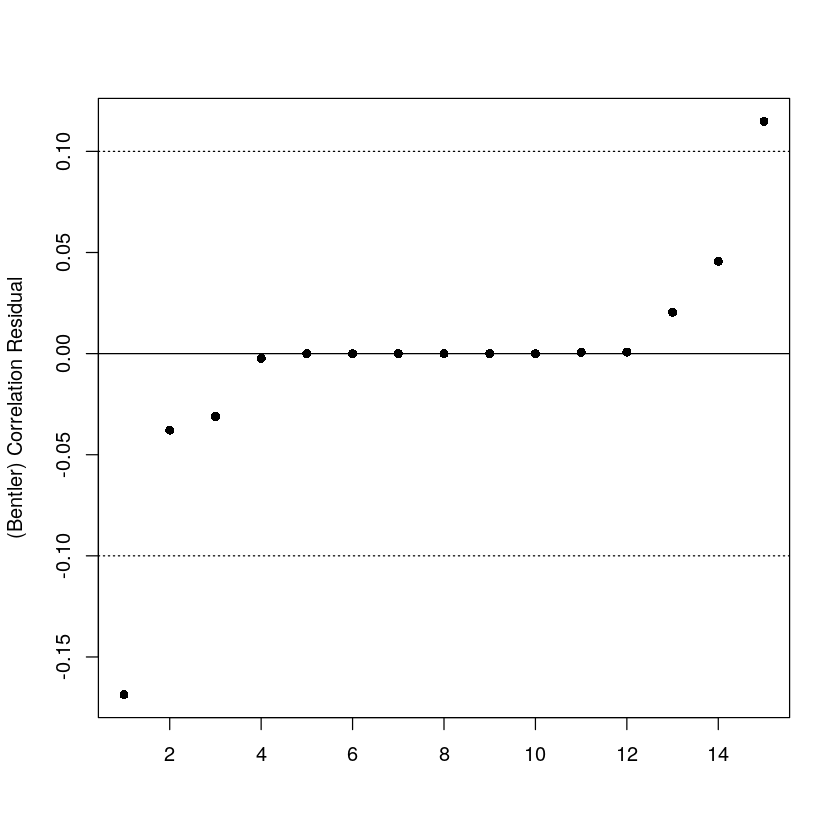

In [22]:
# Extract unique correlation residuals
model.path.fit.resid <- as.data.frame(resid(model.path.fit, type='cor.bentler')$cov)
resid <- model.path.fit.resid[lower.tri(model.path.fit.resid, diag=TRUE)]

summary(resid)

plot(resid[order(resid)], pch=16, xlab='', ylab='(Bentler) Correlation Residual')
abline(h=c(0, -.1, .1), lty=c(1,3,3))

In [23]:
%get model.path.fit.resid --from R
def plot_corr_resid(corr, figsize=None, **kwargs):
    mask = 1 - np.tril(np.ones_like(corr, dtype=np.bool))
    corr_text = np.vectorize('{:.3f}'.format)(corr)
    if figsize is None:
        figsize=np.array([1, 0.75]) * corr.shape[0] + np.array([kwargs.get('cbar', True) * 1.5, 0])
    f, ax = plt.subplots(figsize=figsize)
    cmap = sns.diverging_palette(10, 10, s=50, l=75, sep=100, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, annot=corr_text, fmt='', mask=mask, cmap=cmap, vmin=-0.1, vmax=0.1, 
                square=False, linewidths=.25, **kwargs)
    ax.set_yticklabels(ax.get_yticklabels(), fontdict={'verticalalignment': 'center'})

def save_fig(file, **kwargs):
    pass
#     path = os.path.join(plot_dir, file)
#     plt.savefig(path, metadata={'CreationDate': None})

Variable model.path.fit.resid is put to SoS as model_path_fit_resid


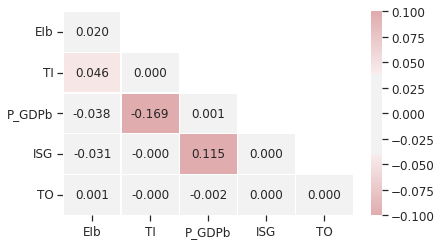

In [24]:
plot_corr_resid(model_path_fit_resid)
save_fig('updated_correlation_residuals.pdf')


Call:
lm(formula = data.logdiff$EIb ~ resid)

Residuals:
       Min         1Q     Median         3Q        Max 
-2.019e-03 -2.238e-04  4.847e-05  3.339e-04  8.922e-04 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.0299769  0.0001215  -246.7   <2e-16 ***
resid        0.9995131  0.0049376   202.4   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.0005952 on 22 degrees of freedom
  (6 observations deleted due to missingness)
Multiple R-squared:  0.9995,	Adjusted R-squared:  0.9994 
F-statistic: 4.098e+04 on 1 and 22 DF,  p-value: < 2.2e-16


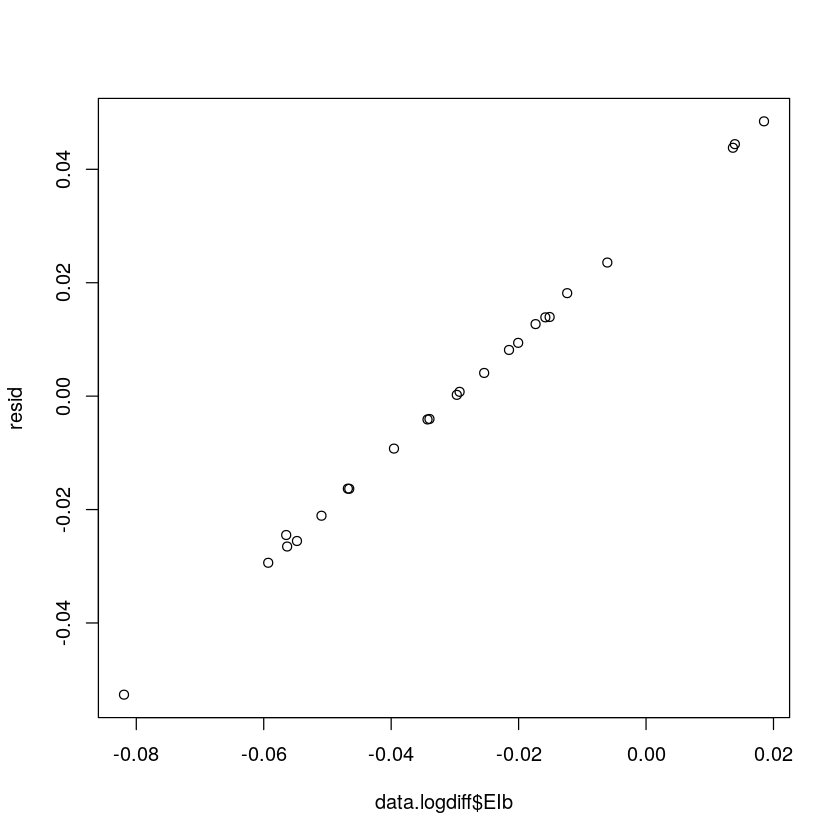

In [25]:
resid <- residuals_lavaan(model.path.fit)$EIb
summary(lm(data.logdiff$EIb ~ resid))
plot(data.logdiff$EIb, resid)